# I. Load Data

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns, squarify

In [11]:
# Đường dẫn đến file Excel
file_path = r"E:\SkyRevenue Insights\0. Data\df_cleaned.xlsx"

# Kiểm tra file có tồn tại không
import os
if os.path.exists(file_path):
    print("File tồn tại!")
else:
    print("File không tồn tại, kiểm tra lại đường dẫn!")
    raise FileNotFoundError("File không tồn tại!")

# Đọc sheet "Data"
df_org = pd.read_excel(file_path)
df = df_org.copy()
# Hiển thị vài dòng đầu của DataFrame để kiểm tra
df.head()

File tồn tại!


,order_id,ticket_id,passenger_id,passenger_gender,passenger_age,ticket_source_name,ticket_status,created_date,departure_date,departure_time,...,seat_class,ticket_price,baggage,insurance_fee,discount_amount,seat_category,age_group,lead_time_days,from,to
0,20205,31268,Xs1fLinPQun+Oy/mD0FlfXMyJD38YlXJfXNbz+qO+5U=,Female,40,IOS,Paid,2023-03-01,2023-03-14,17:55:00,...,I1_ECO,867760,0,0,45000,Economy,Adults (35-59),13,Đắk Lắk,Hồ Chí Minh
1,20190,31242,m/auVlEoaGSe2MqR/Lq4CFXJnI8zauNyF/KiFmMgXHs=,Female,40,GYL,Paid,2023-03-01,2023-03-02,09:30:00,...,Z1_ECO,974280,0,0,45000,Economy,Adults (35-59),1,Đắk Lắk,Hồ Chí Minh
2,20245,31337,6HvtV2vTqUfNBJ53C4TzvJnb0s74KgcRNuUVS+8jRvU=,Female,48,IOS,Paid,2023-03-01,2023-04-10,13:10:00,...,J1_ECO,1423080,0,0,16000,Economy,Adults (35-59),40,Thừa Thiên Huế,Hồ Chí Minh
3,20259,31360,WiK2P31WEd4mckRNVWz0C2aKKRgSrauAG8NdfTLnKjE=,Male,29,Android,New,2023-03-01,2023-04-10,13:10:00,...,J1_ECO,1067310,0,0,45000,Economy,Young Adults (18-34),40,Thừa Thiên Huế,Hồ Chí Minh
4,20255,31355,6HvtV2vTqUfNBJ53C4TzvJnb0s74KgcRNuUVS+8jRvU=,Female,42,IOS,Paid,2023-03-01,2023-04-10,13:10:00,...,J1_ECO,1067310,0,0,24000,Economy,Adults (35-59),40,Thừa Thiên Huế,Hồ Chí Minh


# II. Analysis

In [12]:
df['net_revenue'] = df['ticket_price'] - df['discount_amount'] + df['insurance_fee'] + df['baggage']

In [13]:
# Calculate metrics
unique_passengers = df['passenger_id'].nunique()
total_bookings = df['ticket_id'].count()
avg_booking_per_pax = round(total_bookings / unique_passengers, 2)

# Prepare result DataFrame
metrics_df = pd.DataFrame({
    'Metric': ['Unique Passengers', 'Total Bookings', 'Avg Bookings per Passenger'],
    'Value': [unique_passengers, total_bookings, avg_booking_per_pax]
})

# Also print for quick view in notebook output
print(metrics_df)

                       Metric     Value
0           Unique Passengers   5252.00
1              Total Bookings  18974.00
2  Avg Bookings per Passenger      3.61


              Segment  Customers   Pct
0           Champions       1426  27.2
1             At Risk       1380  26.3
2  Potential Loyalist       1246  23.7
3               Loyal        602  11.5
4              Others        598  11.4


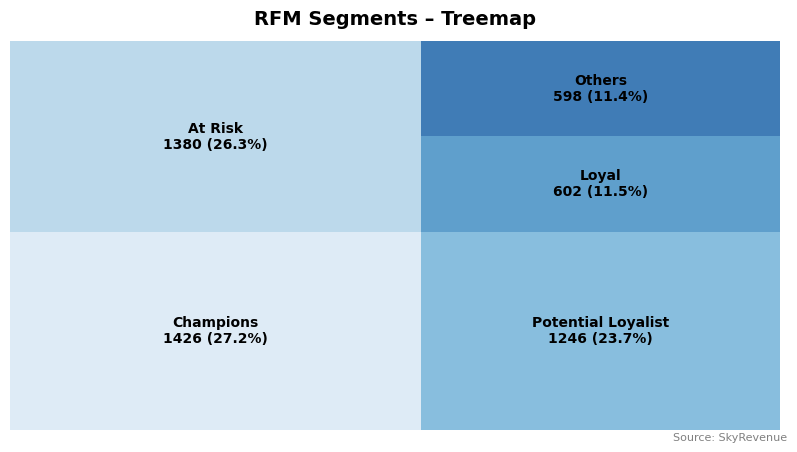

cohort_index    0         1         2
cohort_month                         
2023-03       1.0  0.216955  0.127161
2023-04       1.0  0.129314       NaN
2023-05       1.0       NaN       NaN


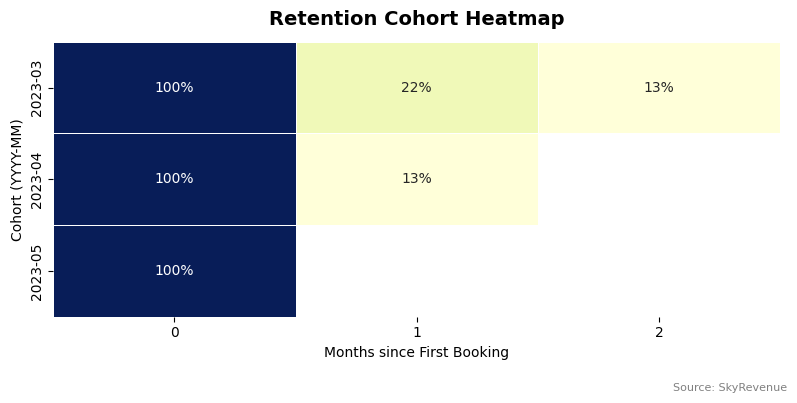

                  Unique_Pax  Share_%
passenger_gender                     
Female                  3311     50.3
Male                    3266     49.7
           Unique_Pax  Share_%
age_group                     
<25              2500     37.0
25-34            2358     34.9
35-44             829     12.3
45-54             564      8.3
55+               507      7.5


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15204\3217150210.py:91: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age = (df.groupby("age_group")["passenger_id"]


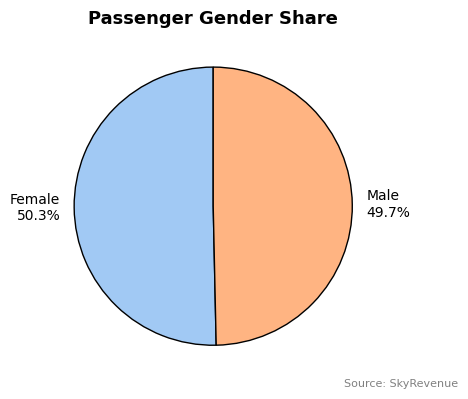

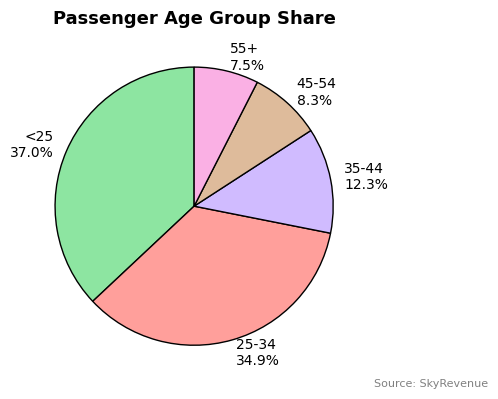

In [20]:
# =============================================================
#          CUSTOMER ANALYTICS DASHBOARD  (design v2)
# =============================================================
# ------------------ 2. RFM SEGMENTATION ----------------------
today = df["created_date"].max() + pd.Timedelta(days=1)

rfm = (
    df.groupby("passenger_id")
      .agg(
          Last_Purchase=("created_date", "max"),
          Frequency=("ticket_id", "count"),
          Monetary=("net_revenue", "sum")
      )
)
rfm["Recency"] = (today - rfm["Last_Purchase"]).dt.days
rfm.drop(columns="Last_Purchase", inplace=True)

# Quartile scores
rfm["R"] = pd.qcut(rfm["Recency"], 4, labels=[4,3,2,1]).astype(int)
rfm["F"] = pd.qcut(rfm["Frequency"].rank(method="first"), 4,
                   labels=[1,2,3,4]).astype(int)
rfm["M"] = pd.qcut(rfm["Monetary"], 4, labels=[1,2,3,4]).astype(int)

def segment(r):
    if r["R"]>=3 and r["F"]>=3:  return "Champions"
    if r["R"]>=3 and r["F"]<=2: return "Potential Loyalist"
    if r["R"]==2 and r["F"]>=3: return "Loyal"
    if r["R"]<=2 and r["F"]<=2: return "At Risk"
    return "Others"
rfm["Segment"] = rfm.apply(segment, axis=1)

# 👉 FIX: reset_index(name='Customers') để cột đếm là int
seg_summary = (rfm["Segment"]
               .value_counts()
               .reset_index(name="Customers")      # <-- đếm
               .rename(columns={"index": "Segment"}))

seg_summary["Pct"] = (
    seg_summary["Customers"] / seg_summary["Customers"].sum() * 100
).round(1)

print(seg_summary)


# ------- Treemap -------
plt.figure(figsize=(8,4.5))
sizes  = seg_summary["Customers"]
labels = [f"{row.Segment}\n{row.Customers} ({row.Pct}%)"
          for row in seg_summary.itertuples()]
colors = sns.color_palette("Blues", len(sizes)).as_hex()
squarify.plot(sizes=sizes, label=labels, color=colors,
              text_kwargs={"weight":"bold"}, alpha=.8)
plt.title("RFM Segments – Treemap", fontsize=14, fontweight="bold", pad=12)
plt.axis("off")
plt.figtext(0.99,0.01,"Source: SkyRevenue",ha="right",fontsize=8,color="gray")
plt.tight_layout(); plt.show()

# ---------- 3. COHORT ----------
df["order_month"]  = df["created_date"].dt.to_period("M")
df["cohort_month"] = df.groupby("passenger_id")["order_month"].transform("min")
df["cohort_index"] = (df["order_month"] - df["cohort_month"]).apply(lambda x: x.n)

coh = (df.groupby(["cohort_month","cohort_index"])["passenger_id"]
         .nunique().reset_index())
coh_pivot = coh.pivot(index="cohort_month", columns="cohort_index",
                      values="passenger_id")
retention = coh_pivot.divide(coh_pivot.iloc[:,0], axis=0)

print(retention)

annot = (retention*100).round(0).astype("Int64").astype(str)+"%"
plt.figure(figsize=(8,4))
sns.heatmap(retention*100, annot=annot, fmt="",
            cmap="YlGnBu", cbar=False, linewidths=.5, linecolor="white")
plt.title("Retention Cohort Heatmap", fontsize=14, fontweight="bold", pad=12)
plt.xlabel("Months since First Booking"); plt.ylabel("Cohort (YYYY-MM)")
plt.tight_layout(rect=[0,0.05,1,1])
plt.figtext(0.99,0.01,"Source: SkyRevenue",ha="right",fontsize=8,color="gray")
plt.show()

# ---------- 4. DEMOGRAPHICS ----------
# Gender
gender = (df.groupby("passenger_gender")["passenger_id"]
            .nunique().to_frame("Unique_Pax"))
gender["Share_%"] = (gender["Unique_Pax"]/gender["Unique_Pax"].sum()*100).round(1)
print(gender)

# Age
bins=[0,24,34,44,54,150]; labels=["<25","25-34","35-44","45-54","55+"]
df["age_group"] = pd.cut(df["passenger_age"], bins=bins, labels=labels)
age = (df.groupby("age_group")["passenger_id"]
         .nunique().to_frame("Unique_Pax"))
age["Share_%"] = (age["Unique_Pax"]/age["Unique_Pax"].sum()*100).round(1)
print(age)

def pie(series, title, palette, size=(6,4)):
    fig, ax = plt.subplots(figsize=size)
    labels=[f"{idx}\n{row['Share_%']}%" for idx,row in series.iterrows()]
    ax.pie(series["Unique_Pax"], labels=labels, colors=palette,
           startangle=90, autopct=lambda pct:"", wedgeprops=dict(edgecolor="black"))
    ax.set_title(title, fontsize=13, fontweight="bold")
    plt.tight_layout(); plt.figtext(0.99,0.02,"Source: SkyRevenue",
                                    ha="right",fontsize=8,color="gray")
    plt.show()

pie(gender, "Passenger Gender Share",
    sns.color_palette("pastel")[:len(gender)], (5,4))
pie(age, "Passenger Age Group Share",
    sns.color_palette("pastel")[2:2+len(age)], (6,4))